# Model‑free control in action: SARSA vs Q‑learning on `CliffWalking-v1`

This case study walks through **tabular model‑free control** in Gymnasium with a single environment:

- **CliffWalking-v1** (Discrete state/action spaces)

We will train and compare two classic TD control algorithms:

- **SARSA** (on‑policy TD control)
- **Q‑learning** (off‑policy TD control)

Both use **$\epsilon$‑greedy exploration** and learn an action‑value function $Q(s,a)$.

**What you’ll get at the end**
- Learning curves (episode return vs episode) for SARSA and Q‑learning  
- Clean 2D visuals:
  - **state value heatmap** $V(s)=\max_a Q(s,a)$
  - **recommended action** (greedy policy arrows)
  - **greedy rollout path** from the start state to termination


In [1]:
# If running on a fresh environment, you may need:
# !pip -q install "gymnasium[toy-text]"

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

from dataclasses import dataclass
from IPython.display import Image, display

SEED = 0
random.seed(SEED)
np.random.seed(SEED)


### Environment: CliffWalking

CliffWalking is a 2D gridworld. The agent starts in the bottom‑left and must reach the goal in the bottom‑right.

- Each move gives **−1**
- Stepping into the cliff gives **−100** and ends the episode (you fall and reset)
- Reaching the goal ends the episode

In the standard layout there are **4 rows × 12 columns** (48 states) and 4 actions (up/right/down/left).

Reference: Gymnasium documentation for `CliffWalking-v1`.


In [3]:
display(Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif"))

In [4]:
import gymnasium as gym

env_id = "CliffWalking-v1"
env = gym.make(env_id)

nS = env.observation_space.n
nA = env.action_space.n

print("state space:", env.observation_space)
print("action space:", env.action_space)
env.close()

state space: Discrete(48)
action space: Discrete(4)


### $\epsilon$‑greedy exploration

At each state $s$:
- with probability $1-\epsilon$, choose a greedy action $\arg\max_a Q(s,a)$  
- with probability $\epsilon$, choose a random action

We’ll use an exponential decay schedule over episodes:
$$
\epsilon(e)=\epsilon_{\min}+(\epsilon_{\max}-\epsilon_{\min})\exp(-k e).
$$


In [5]:
def epsilon_by_episode(ep: int, eps_max: float, eps_min: float, decay: float) -> float:
    return eps_min + (eps_max - eps_min) * np.exp(-decay * ep)

def epsilon_greedy(Q: np.ndarray, s: int, eps: float, nA: int) -> int:
    if random.random() < eps:
        return random.randrange(nA)
    return int(np.argmax(Q[s]))

def smooth(x, w=50):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w)/w, mode="valid")

### TD control algorithms

### SARSA (on‑policy)
SARSA updates using the **next action actually taken** by the behavior policy:
$$
Q(s,a)\leftarrow Q(s,a)+\alpha\Big[r+\gamma Q(s',a')-Q(s,a)\Big].
$$
Because $a'$ is drawn from the current $\epsilon$‑greedy policy, SARSA is **on‑policy**.

### Q‑learning (off‑policy)
Q‑learning updates toward the **greedy** value at the next state:
$$
Q(s,a)\leftarrow Q(s,a)+\alpha\Big[r+\gamma \max_{a'} Q(s',a')-Q(s,a)\Big].
$$
The target is greedy even while the behavior may be exploratory, so Q‑learning is **off‑policy**.

**In CliffWalking, this difference is visible.**
- Q‑learning often learns a shorter but riskier path near the cliff (because it evaluates as if you will act greedily later).
- SARSA often learns a safer path that accounts for exploration risk.


In [6]:
@dataclass
class ControlArgs:
    learning_rate: float = 0.5      # alpha
    discount_factor: float = 1.0    # gamma
    max_epsilon: float = 1.0
    min_epsilon: float = 0.05
    epsilon_decay_rate: float = 0.001


In [8]:
import gymnasium as gym

def train_sarsa(env_id: str, episodes: int, args: ControlArgs, seed: int = 0):
    env = gym.make(env_id)
    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)

    returns = []
    for ep in range(1, episodes + 1):
        eps = epsilon_by_episode(ep, args.max_epsilon, args.min_epsilon, args.epsilon_decay_rate)

        s, _ = env.reset(seed=seed + ep)
        a = epsilon_greedy(Q, s, eps, nA)

        G = 0.0
        done = False
        while not done:
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            G += r

            if done:
                td_target = r
                td_error = td_target - Q[s, a]
                Q[s, a] += args.learning_rate * td_error
                break

            a2 = epsilon_greedy(Q, s2, eps, nA)
            td_target = r + args.discount_factor * Q[s2, a2]
            td_error = td_target - Q[s, a]
            Q[s, a] += args.learning_rate * td_error

            s, a = s2, a2

        returns.append(G)

    env.close()
    return Q, np.array(returns)


def train_q_learning(env_id: str, episodes: int, args: ControlArgs, seed: int = 0):
    env = gym.make(env_id)
    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros((nS, nA), dtype=float)

    returns = []
    for ep in range(1, episodes + 1):
        eps = epsilon_by_episode(ep, args.max_epsilon, args.min_epsilon, args.epsilon_decay_rate)

        s, _ = env.reset(seed=seed + ep)
        G = 0.0
        done = False
        while not done:
            a = epsilon_greedy(Q, s, eps, nA)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            G += r

            best_next = 0.0 if done else float(np.max(Q[s2]))
            td_target = r + args.discount_factor * best_next
            td_error = td_target - Q[s, a]
            Q[s, a] += args.learning_rate * td_error

            s = s2

        returns.append(G)

    env.close()
    return Q, np.array(returns)


In [9]:
import gymnasium as gym

def evaluate_greedy(env_id: str, Q: np.ndarray, n_eval_episodes: int = 100, seed: int = 123, max_steps: int = 10_000):
    env = gym.make(env_id)
    episode_returns = []

    for k in range(n_eval_episodes):
        s, _ = env.reset(seed=seed + k)
        G = 0.0
        for _ in range(max_steps):
            a = int(np.argmax(Q[s]))
            s, r, terminated, truncated, _ = env.step(a)
            G += r
            if terminated or truncated:
                break
        episode_returns.append(G)

    env.close()
    episode_returns = np.array(episode_returns, dtype=float)
    return float(episode_returns.mean()), float(episode_returns.std())


In [10]:
import gymnasium as gym

# --- Visualization helpers (2D grid value, policy arrows, greedy path) ---

def cliffwalking_shape(nS: int):
    # Standard CliffWalking is 4x12 (48 states)
    if nS == 48:
        return 4, 12
    # fallback: factorization
    nrow = int(np.sqrt(nS))
    while nS % nrow != 0:
        nrow -= 1
    return nrow, nS // nrow

def s_to_rc(s: int, ncol: int):
    return (s // ncol, s % ncol)

def add_cliff_start_goal(ax, nrow: int, ncol: int):
    # Standard cliff: bottom row, columns 1..ncol-2
    for c in range(1, ncol-1):
        ax.text(c, nrow-1, "C", ha="center", va="center", fontsize=10)
    # start and goal
    ax.scatter([0], [nrow-1], marker="*", s=200)
    ax.scatter([ncol-1], [nrow-1], marker="X", s=120)

def plot_value_and_policy(Q: np.ndarray, title: str = ""):
    nS, nA = Q.shape
    nrow, ncol = cliffwalking_shape(nS)

    V = Q.max(axis=1).reshape(nrow, ncol)
    pi = Q.argmax(axis=1).reshape(nrow, ncol)

    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(V, origin="upper")
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
    ax.set_title(title or "V(s)=max_a Q(s,a) with greedy policy")

    # action mapping (CliffWalking): 0=Up, 1=Right, 2=Down, 3=Left
    dx = np.zeros((nrow, ncol))
    dy = np.zeros((nrow, ncol))
    dx[pi == 1] =  1
    dx[pi == 3] = -1
    dy[pi == 2] =  1
    dy[pi == 0] = -1

    X, Y = np.meshgrid(np.arange(ncol), np.arange(nrow))
    ax.quiver(X, Y, dx, dy, angles="xy", scale_units="xy", scale=2.5, width=0.003)

    add_cliff_start_goal(ax, nrow, ncol)

    ax.set_xticks(np.arange(ncol))
    ax.set_yticks(np.arange(nrow))
    ax.grid(which="both", linewidth=0.5)
    plt.show()


def rollout_greedy_path(env_id: str, Q: np.ndarray, seed: int = 123, max_steps: int = 1000):
    env = gym.make(env_id)
    s, _ = env.reset(seed=seed)
    path = [s]
    total_reward = 0.0

    for _ in range(max_steps):
        a = int(np.argmax(Q[s]))
        s2, r, terminated, truncated, _ = env.step(a)
        total_reward += r
        path.append(s2)
        s = s2
        if terminated or truncated:
            break

    env.close()
    return path, total_reward


def plot_greedy_path(Q: np.ndarray, title: str = "", seed: int = 123):
    nS, _ = Q.shape
    nrow, ncol = cliffwalking_shape(nS)

    V = Q.max(axis=1).reshape(nrow, ncol)
    path, G = rollout_greedy_path(env_id, Q, seed=seed)

    coords = np.array([s_to_rc(s, ncol) for s in path])
    rows, cols = coords[:, 0], coords[:, 1]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.imshow(V, origin="upper")
    ax.plot(cols, rows, linewidth=2)

    add_cliff_start_goal(ax, nrow, ncol)
    ax.set_title((title or "Greedy rollout path") + f"  |  return={G:.1f}, steps={len(path)-1}")

    ax.set_xticks(np.arange(ncol))
    ax.set_yticks(np.arange(nrow))
    ax.grid(which="both", linewidth=0.5)
    plt.show()


def plot_learning_curves(returns_sarsa, returns_q, w=50):
    plt.figure(figsize=(10,4))
    plt.plot(smooth(returns_sarsa, w=w), label=f"SARSA (smoothed w={w})")
    plt.plot(smooth(returns_q, w=w), label=f"Q-learning (smoothed w={w})")
    plt.title("Training learning curves (episode return)")
    plt.xlabel("Episode (smoothed index)")
    plt.ylabel("Return")
    plt.legend()
    plt.show()


### Train SARSA


In [11]:
args = ControlArgs(
    learning_rate=0.5,
    discount_factor=1.0,
    max_epsilon=1.0,
    min_epsilon=0.05,
    epsilon_decay_rate=0.001
)

episodes = 5000

Q_sarsa, returns_sarsa = train_sarsa(env_id, episodes=episodes, args=args, seed=SEED)
mean_sarsa, std_sarsa = evaluate_greedy(env_id, Q_sarsa, n_eval_episodes=200, seed=SEED)

print(f"SARSA greedy eval return: mean={mean_sarsa:.2f}, std={std_sarsa:.2f}")


SARSA greedy eval return: mean=-10000.00, std=0.00


### Train Q‑learning


In [12]:
Q_ql, returns_ql = train_q_learning(env_id, episodes=episodes, args=args, seed=SEED)
mean_ql, std_ql = evaluate_greedy(env_id, Q_ql, n_eval_episodes=200, seed=SEED)

print(f"Q-learning greedy eval return: mean={mean_ql:.2f}, std={std_ql:.2f}")


Q-learning greedy eval return: mean=-13.00, std=0.00


### Compare learning curves


In [ ]:
plot_learning_curves(returns_sarsa, returns_ql, w=50)


### Final policies and paths


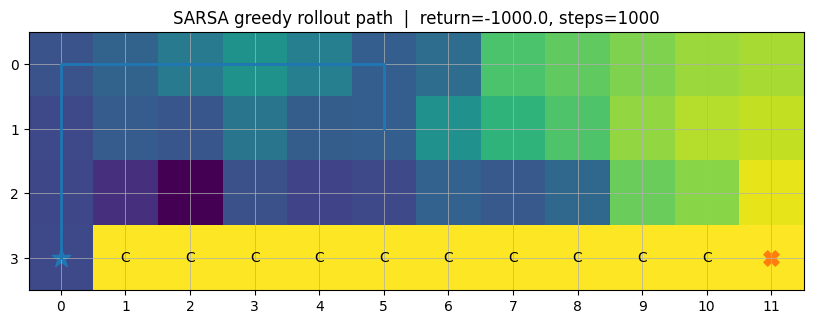

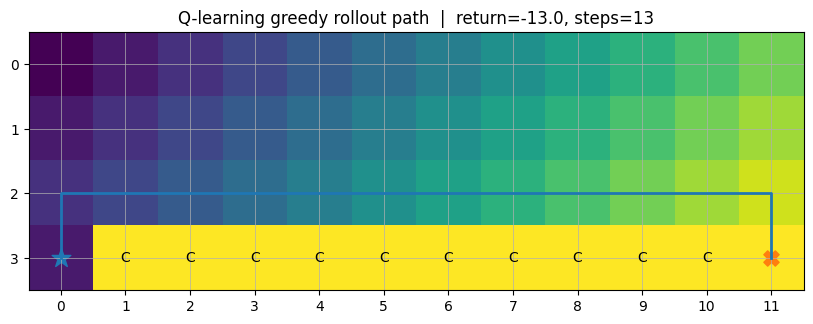

In [17]:
#plot_value_and_policy(Q_sarsa, title="SARSA: V(s) and greedy policy")
plot_greedy_path(Q_sarsa, title="SARSA greedy rollout path", seed=1253)

#plot_value_and_policy(Q_ql, title="Q-learning: V(s) and greedy policy")
plot_greedy_path(Q_ql, title="Q-learning greedy rollout path", seed=1253)


In CliffWalking, exploration itself is risky: even if the greedy policy avoids the cliff, an $\epsilon$‑greedy behavior policy can still occasionally take a bad action near the edge.

- **SARSA (on‑policy)** learns values consistent with the *behavior policy* (includes exploration), so it often prefers a **safer route** away from the cliff.
- **Q‑learning (off‑policy)** learns values for the *greedy target policy*, so it often converges to a **shorter route** close to the cliff.

If you change $\epsilon$ decay (slower decay ⇒ more exploration for longer), SARSA tends to become even more conservative.

